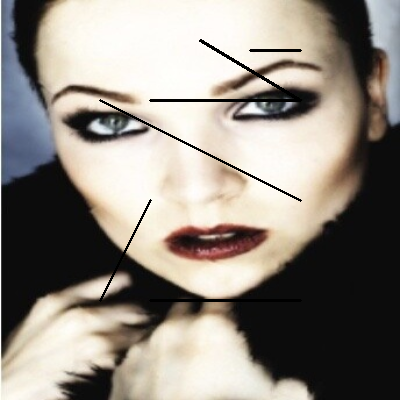

<ipython-input-1-19f1bf00a8cf>:70: RuntimeWarning: overflow encountered in ubyte_scalars
  lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
<ipython-input-1-19f1bf00a8cf>:74: RuntimeWarning: overflow encountered in ubyte_scalars
  gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])
<ipython-input-1-19f1bf00a8cf>:28: RuntimeWarning: overflow encountered in ubyte_scalars
  d = 2.0 - (T1 - T2) ** 2


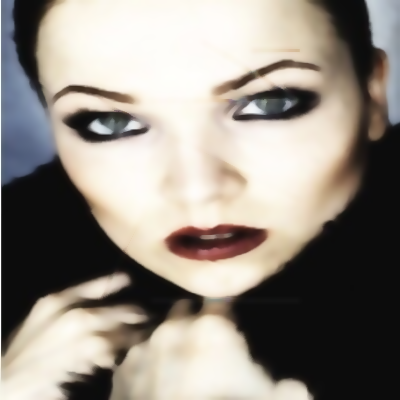

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math
KNOWN = 0
BAND = 1
INSIDE = 2
EPS = 1e-6

def solve(i1, j1, i2, j2,T,f):
    MAX_VALUE = 1000000
    sol = MAX_VALUE

    if i1 < 0 or i1 >= T.shape[0] or j1 < 0 or j1 >= T.shape[1]:
        return sol

    if i2 < 0 or i2 >= T.shape[0] or j2 < 0 or j2 >= T.shape[1]:
        return sol

    flag1 = f[i1, j1]
    flag2 = f[i2, j2]


    if flag1 == KNOWN and flag2 == KNOWN:
        T1 = T[i1, j1]
        T2 = T[i2, j2]
        d = 2.0 - (T1 - T2) ** 2
        if d > 0.0:
            r = math.sqrt(d)
            s = (T1 + T2 - r) / 2.0
            if s >= T1 and s >= T2:
                return s
            else:
                s += r
                if s <= T1 and s <= T2:
                    return s


    if flag1 == KNOWN:
        T1 = T[i1, j1]
        return 1.0 + T1
    elif flag2 == KNOWN:
        T2 = T[i2, j2]
        return 1.0 + T2


    return sol


def inpaint(i, j, T, image):
    b=1

    Be = [(i - b, j), (i + b, j), (i, j - b), (i, j + b)]
    grad_T = np.gradient(T)
    gradI = np.array([0, 0])


    for z in range(3):
        Ia = 0
        s = 0
        for x in Be:
            if 0 <= x[0] < image.shape[0] and 0 <= x[1] < image.shape[1] and f[x[0],x[1]]==KNOWN :
                r = np.array([x[0] - i, x[1] - j])
                dot_gradt_r = (grad_T[0][i, j] * r[0]) + (grad_T[1][i, j] * r[1])
                dir = dot_gradt_r / (np.linalg.norm(r, 1))
                if dir==0:
                  dir=EPS
                dst = 1 / (np.linalg.norm(r, 1) ** 2)
                lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
                w = (dir * dst * lev)

                if (0 <= x[0] + 1 < image.shape[0] and 0 <= x[1] + 1 < image.shape[1] and 0 <= x[0] - 1 and x[1] - 1 >= 0):
                    gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])
                dot_gradi_r = (gradI[0] * r[0]) + (gradI[1] * r[1])
                Ia += w * (image[x[0], x[1], z] + dot_gradi_r)
                s += w
        if s!=0:
          image[i, j, z] = Ia / s
        else:
          image[i, j, z] = 0
    return image


image =cv2.imread("/content/imagepresent1 (1).jpg")

image=cv2.resize(image, (400, 400))
lines = [((150, 100), (300, 100)),
         ((100, 100), (300, 200)),
         ((150, 300), (300, 300)),
         ((200, 40), (300, 100)),
         ((250, 50), (300, 50)),
         ((150, 200), (100, 300)),
         ((200, 150), (100, 100)),]

# Draw the lines on the image
for line in lines:
    image=cv2.line(image, line[0], line[1], (0, 0, 0), 2)

cv2_imshow(image)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
T = np.zeros_like(gray_image)
narrow_band = []
f = np.zeros_like(gray_image)

for i in range(0, gray_image.shape[0]):
    for j in range(0, gray_image.shape[1]):
       if gray_image[i, j] != 0:
        T[i, j] = 0
        f[i,j] = KNOWN
        if gray_image[min(i+1,gray_image.shape[0]-1), j]== 0 or gray_image[max(i-1,0), j]== 0 or gray_image[i,min(j+1,gray_image.shape[0]-1)]==0 or gray_image[i ,max(j-1,0)]==0:
            f[i,j]=BAND
            narrow_band.append([i, j])
       else:
            T[i, j] =1000000
            f[i,j]=INSIDE

for iteration in range(1):

  while narrow_band:
      min_distance = 1000000
      min_point = None

      for point in narrow_band:
          if T[point[0], point[1]] < min_distance:
              min_distance = T[point[0], point[1]]
              min_point = point

      current_point = min_point

      if current_point is None:
          break
      f[current_point[0],current_point[1]]=KNOWN
      narrow_band.remove(current_point)

      neighbors = [(current_point[0] - 1, current_point[1]),(current_point[0] + 1, current_point[1]),(current_point[0], current_point[1] - 1),(current_point[0], current_point[1] + 1)]

      for neighbor in neighbors:
        if 0 <= neighbor[0] < image.shape[0] and 0 <= neighbor[1] < image.shape[1]:
          if f[neighbor[0],neighbor[1]]!=KNOWN:
            if f[neighbor[0],neighbor[1]]==INSIDE:
              f[neighbor[0],neighbor[1]]=BAND
              b=10
              inpaint(neighbor[0],neighbor[1],T,image)
            T[neighbor[0],neighbor[1]]=min(solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]+1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]+1,T,f))
            narrow_band.append(neighbor)

kernel_size = 5

# Apply median blur to the image
blurred_image = cv2.medianBlur(image, kernel_size)

d = 9  # Diameter of each pixel neighborhood
sigma_color = 75  # Color similarity
sigma_space = 75  # Space similarity

# Apply bilateral filtering
filtered_image = cv2.bilateralFilter(blurred_image, d, sigma_color, sigma_space)

cv2_imshow(filtered_image)
